In [411]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.spatial as sc

In [518]:
image_folder_path = "./fruit-inspection-images"
images_second_task_path = os.path.join(image_folder_path, "second-task")
images_second_task = os.listdir(images_second_task_path)

ir_images = []
color_images = []

for img in images_second_task:
    if img[:2] == "C0":
        ir_images.append(img)
    else:
        color_images.append(img)

def load_image(image_number, ir = True):
    ir_image_path = os.path.join(images_second_task_path, ir_images[image_number])
    color_image_path = os.path.join(images_second_task_path, color_images[image_number])
    image = cv2.imread(ir_image_path if ir else color_image_path, cv2.IMREAD_COLOR)
    return image

def load_image_grey(image_number, ir = True):
    ir_image_path = os.path.join(images_second_task_path, ir_images[image_number])
    color_image_path = os.path.join(images_second_task_path, color_images[image_number])
    image = cv2.imread(ir_image_path if ir else color_image_path, cv2.IMREAD_GRAYSCALE)
    return image



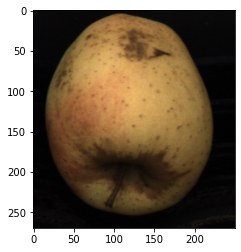

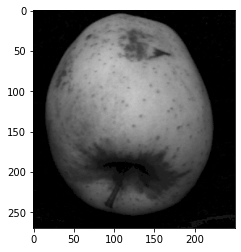

In [535]:
def show_image(image, grey = False):
    if not grey:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap="gray", vmin=0, vmax=255)
    plt.show()

image = load_image(0, False)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_image(image)


image_grey = load_image_grey(0, False)
show_image(image_grey, True)

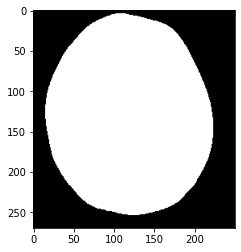

In [527]:
ret, th = cv2.threshold(image_grey, 25, 255, cv2.THRESH_BINARY) #Todo, finn bedre threshold

#Floodfill and invert
th_copy = bin.copy()
h, w = th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(th_copy, mask, (0,0), 255)
th_inv = cv2.bitwise_not(th_copy)
im_out = th | th_inv

smooth_image = cv2.medianBlur(im_out, 3)
#smooth_image = cv2.GaussianBlur(im_out,(3,3),0)
show_image(smooth_image, True)

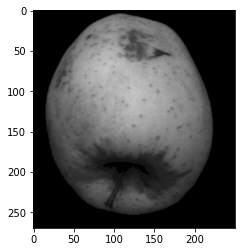

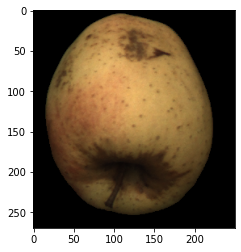

In [536]:
#Get the fruit from the mask
img_fuit = smooth_image & image_grey
show_image(img_fuit, True)


img_fruit_color = image.copy()
for i in range(3):
    img_fruit_color[:,:,i] =  smooth_image & image[:, :, i]

show_image(img_fruit_color)

136.59533102766798 157.51585968379447


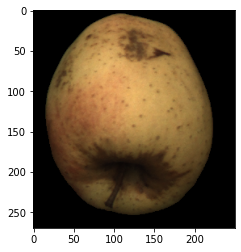

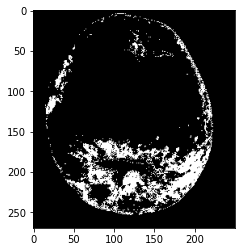

In [545]:
#cv2.Mahalanobis(v1, v2, icova)

#Try out different color spaces here
img_fruit_color_LAB = cv2.cvtColor(img_fruit_color, cv2.COLOR_RGB2LAB)
img_fruit_color_AB = img_fruit_color_LAB[:, :, 1:3]

img_fruit_color_GB = img_fruit_color_AB.reshape(img_fruit_color_AB.shape[0] * img_fruit_color_AB.shape[1], 2)
cov, mean = cv2.calcCovarMatrix(img_fruit_color_GB, None, cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
cov_inv = cv2.invert(cov)

russet = np.zeros((img_fruit_color_LAB.shape[0], img_fruit_color_LAB.shape[1]), dtype="float64")

mask = np.array(smooth_image,dtype=bool )

mean1 = np.mean(img_fruit_color_LAB[:,:,1], where = mask)
mean2 = np.mean(img_fruit_color_LAB[:,:,2], where = mask)
print(mean1, mean2)
        
#128 svart

for i in range(img_fruit_color_LAB.shape[0]):
        for j in range(img_fruit_color_LAB.shape[1]):
                if img_fruit_color_LAB[i][j][1] != 128 and img_fruit_color_LAB[i][j][2] != 128 : #is a fruit pixel

                        pixel = np.array(img_fruit_color_LAB[i][j])[1:3].reshape(1, 2)

                        #distance = cv2.Mahalanobis(pixel, mean, cov_inv[1])
                        distance = sc.distance.cdist(pixel, mean, 'mahalanobis', VI=cov_inv[1])
                        
                        #A distance of 1 or lower shows that the point is right among
                        #the benchmark points
                        if distance < 0.8:
                                russet[i][j] = 255
show_image(img_fruit_color)
show_image(russet, True)
